## Install and import required libraries

In [ ]:
# pip install yfinance 

# yfinance is a python library which retrieves real time market value

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import arch
import yfinance as yf

from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU
from keras.models import Sequential

register_matplotlib_converters()
warnings.filterwarnings("ignore")

## Loading Bitcoin value (BTC-USD)

In [12]:
btc = yf.Ticker("BTC-USD")

# get stock info
print(btc.info)

# get historical market data
hist = btc.history(period="5d", interval = "1m")
df = hist.reset_index()
df

{'companyOfficers': [], 'name': 'Bitcoin', 'startDate': 1367107200, 'description': 'Bitcoin (BTC) is a cryptocurrency . Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 18,721,987. The last known price of Bitcoin is 35,387.50455597 USD and is up 1.53 over the last 24 hours. It is currently trading on 9728 active market(s) with $42,723,213,076.31 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'maxAge': 1, 'previousClose': 35508.32, 'regularMarketOpen': 35508.32, 'twoHundredDayAverage': 40968.258, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': 30283683840, 'regularMarketDayHigh': 35843.113, 'navPrice': None, 'averageDailyVolume10Day': 62474051689, 'totalAssets': None, 'regularMarketPreviousClose': 35508.32, 'fiftyDayAverage': 51164.438, 'trailingAnnualDividendRate': None, 'open': 35508.32, 'toCurrency': 'USD=X', 'averageVolume10days': 62474051689, 'expireDate': None, 'yield': No

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-05-27 00:00:00+01:00,39019.730469,39019.730469,39019.730469,39019.730469,0,0,0
1,2021-05-27 00:01:00+01:00,38978.664062,38978.664062,38978.664062,38978.664062,0,0,0
2,2021-05-27 00:02:00+01:00,38937.027344,38937.027344,38937.027344,38937.027344,0,0,0
3,2021-05-27 00:03:00+01:00,38897.214844,38897.214844,38897.214844,38897.214844,0,0,0
4,2021-05-27 00:04:00+01:00,38783.230469,38783.230469,38783.230469,38783.230469,0,0,0
...,...,...,...,...,...,...,...,...
5760,2021-05-31 02:24:00+01:00,35133.242188,35133.242188,35133.242188,35133.242188,0,0,0
5761,2021-05-31 02:25:00+01:00,35135.472656,35135.472656,35135.472656,35135.472656,0,0,0
5762,2021-05-31 02:26:00+01:00,35134.828125,35134.828125,35134.828125,35134.828125,50292736,0,0
5763,2021-05-31 02:27:00+01:00,35166.355469,35166.355469,35166.355469,35166.355469,1447936,0,0


## Data Preprocessing

In [13]:
# feature creation for better representation of price on a day
df['Mean'] = (df['Low'] + df['High'])/2

# remove NaNs and Nones
df=df.drop(columns=['Dividends','Stock Splits'])

# data preview
print(df.head())

                   Datetime          Open          High           Low  \
0 2021-05-27 00:00:00+01:00  39019.730469  39019.730469  39019.730469   
1 2021-05-27 00:01:00+01:00  38978.664062  38978.664062  38978.664062   
2 2021-05-27 00:02:00+01:00  38937.027344  38937.027344  38937.027344   
3 2021-05-27 00:03:00+01:00  38897.214844  38897.214844  38897.214844   
4 2021-05-27 00:04:00+01:00  38783.230469  38783.230469  38783.230469   

          Close  Volume          Mean  
0  39019.730469       0  39019.730469  
1  38978.664062       0  38978.664062  
2  38937.027344       0  38937.027344  
3  38897.214844       0  38897.214844  
4  38783.230469       0  38783.230469  


In [14]:
# Creating a copy for making small changes
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift()

# date time typecast
dataset_for_prediction['Datetime'] =pd.to_datetime(dataset_for_prediction['Datetime'])
dataset_for_prediction.index= dataset_for_prediction['Datetime']

In [16]:
df_final = dataset_for_prediction[['Datetime', 'Actual']]
df_final = df_final.reset_index(drop=True)
df_final = df_final.dropna()
df_final

,Datetime,Actual
1,2021-05-27 00:01:00+01:00,39019.730469
2,2021-05-27 00:02:00+01:00,38978.664062
3,2021-05-27 00:03:00+01:00,38937.027344
4,2021-05-27 00:04:00+01:00,38897.214844
5,2021-05-27 00:05:00+01:00,38783.230469
...,...,...
5760,2021-05-31 02:24:00+01:00,35091.679688
5761,2021-05-31 02:25:00+01:00,35133.242188
5762,2021-05-31 02:26:00+01:00,35135.472656
5763,2021-05-31 02:27:00+01:00,35134.828125


In [17]:
price = np.array(df_final['Actual'].tolist())

time = np.array(df_final['Datetime'].tolist())


In [19]:
price = price.reshape(5764,1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [20]:
scaler.fit(price[:1441])

price = scaler.transform(price)

df = pd.DataFrame(price.reshape(1441,4), columns = ['First', 'Second', 'Third', 'Target'])


In [21]:
df

,First,Second,Third,Target
0,0.250711,0.194640,0.137790,0.083431
1,-0.072201,-0.041667,0.024191,0.076625
2,0.171210,0.192656,0.219937,0.225115
3,0.126312,0.045259,0.105655,0.065425
4,0.061254,0.085249,0.165679,0.202005
...,...,...,...,...
1436,-4.801653,-4.828801,-4.887459,-4.806416
1437,-4.777188,-4.761844,-4.833292,-4.866317
1438,-4.997420,-4.884061,-4.995148,-5.011831
1439,-4.995655,-4.920271,-4.947722,-5.112571


## Creating the Train-Test data

In [22]:
# 75% train, 25% test

x_train = df.iloc[:360, :3]
y_train = df.iloc[:360, -1]

x_test = df.iloc[361:, :3]
y_test = df.iloc[361:, -1]

In [23]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [25]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## GRU Model

In [27]:
model = Sequential()
model.add(GRU(20, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(GRU(40))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 20)             1320      
_________________________________________________________________
gru_1 (GRU)                  (None, 40)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 8,681
Trainable params: 8,681
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(x_train, y_train, batch_size=5, epochs = 100)

Epoch 1/100
72/72 [==============================] - 16s 3ms/step - loss: 0.5304
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 3/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 4/100
72/72 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 5/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 6/100
72/72 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 7/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 8/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 9/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 10/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 11/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 12/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 13/100
72/72 [================

In [29]:
y_pred = model.predict(x_test)

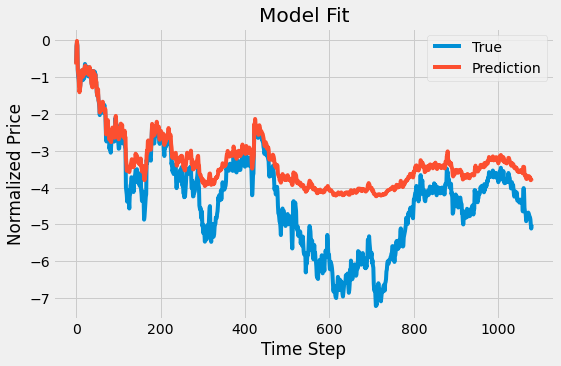

In [30]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()

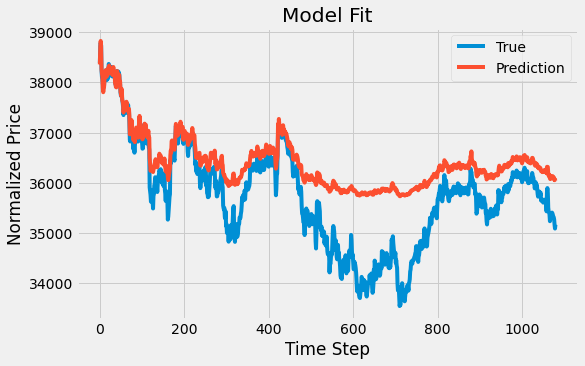

In [31]:
# we need to inverse tranform to check the original values, since we had scaled it previously

plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(scaler.inverse_transform(y_pred), label='Prediction')
plt.legend()

In [32]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred)))
print ('Test Score {} RMSE'.format(testScore))

Test Score 847.5939301655781 RMSE
